In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_BookCrossing'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(390999, 18)

In [12]:
bs=64

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(77805, 185973)

In [16]:
len(dltrain)

6110

In [17]:
6110*64

391040

## Model Architecture

In [44]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.3

In [45]:
n_users

77805

In [46]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [47]:
n_users

77805

In [48]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [49]:
cfobj

cf(
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [50]:
for Xb, Yb in dltrain:
    break

In [51]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [52]:
cfobj.forward(Xb,Yb)

(tensor([[6.2112],
         [1.2307],
         [7.8915],
         [9.4469],
         [1.1495],
         [7.0367],
         [2.8037],
         [4.4593],
         [2.5468],
         [5.0535],
         [5.8075],
         [1.6728],
         [9.9493],
         [9.9975],
         [2.6829],
         [5.7712],
         [5.9321],
         [4.2626],
         [5.6234],
         [6.4642],
         [9.6744],
         [2.3549],
         [9.2391],
         [7.8668],
         [6.9265],
         [3.1221],
         [7.7049],
         [6.1611],
         [9.9303],
         [6.5732],
         [5.1396],
         [9.3119],
         [2.6252],
         [2.2023],
         [1.0051],
         [1.0246],
         [1.9480],
         [7.1970],
         [4.7673],
         [9.5806],
         [7.7305],
         [2.5782],
         [1.1360],
         [1.5219],
         [3.0505],
         [8.3955],
         [2.4183],
         [2.3952],
         [7.6221],
         [1.1791],
         [1.3251],
         [1.1538],
         [1.

## Learner

In [53]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} ')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [54]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [55]:
device='cuda:1'

In [56]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [57]:
cfobj=cfobj.to(device)

In [58]:
cfobj

cf(
  (emb_user): Embedding(77806, 25)
  (emb_item): Embedding(185974, 25)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (ub): Embedding(77806, 1)
  (ib): Embedding(185974, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [59]:
len(dltrain)

6110

In [60]:
wd=5e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-4,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,10000,0.25,cycle_mult=0)

In [61]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

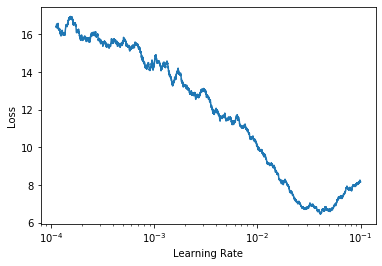

In [62]:
learner.plot_lrs(100)

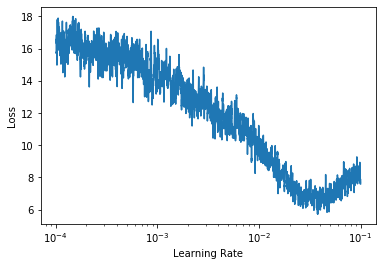

In [63]:
learner.plot_lrs(10)

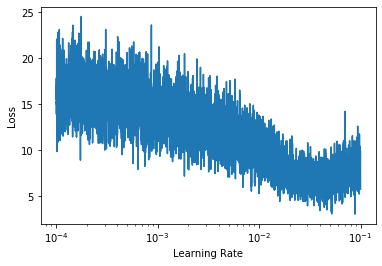

In [64]:
learner.plot_lrs(1)

In [65]:
del cfobj
torch.cuda.empty_cache()

In [66]:
print (wd)

5e-05


In [67]:
wd=5e-5
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [68]:
device

'cuda:1'

In [69]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=2e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0,start_lr=2e-2,end_lr=1e-3,wd_mult=1.2)

In [70]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.576700727912291                 Valid Loss:4.202218817985397 Train RMSE:2.344515741755734 Valid RMSE:2.033468444743986 
Epoch:1 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.128656055650227                 Valid Loss:4.173729431504074 Train RMSE:2.253480037846285 Valid RMSE:2.026446357830525 


In [71]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.1403379002491505                 Valid Loss:4.1837221889839 Train RMSE:2.2564332249042782 Valid RMSE:2.0281654394817523 
Epoch:1 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.143358502138266                 Valid Loss:4.216471286727928 Train RMSE:2.2569075602588553 Valid RMSE:2.036855603169443 
Epoch:2 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.137240613150714                 Valid Loss:4.185519789291107 Train RMSE:2.25591577282 Valid RMSE:2.0295645934734305 


In [72]:
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=2,start_lr=9e-3,end_lr=1e-3,wd_mult=1.2)

In [73]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.111104536641834                 Valid Loss:4.167400059492691 Train RMSE:2.250344325873013 Valid RMSE:2.0248205313365317 
Epoch:1 Learning rate 0.00447213595499958 Weight Decay 6e-05 Train Loss:4.093437598418877                 Valid Loss:3.686117909301346 Train RMSE:2.014095475904836 Valid RMSE:1.9005718478476037 
Epoch:2 Learning rate 0.001 Weight Decay 7.2e-05 Train Loss:3.5876581431605814                 Valid Loss:3.7264117549384372 Train RMSE:1.8864539818779087 Valid RMSE:1.911254364411327 
Epoch:3 Learning rate 0.02 Weight Decay 5e-05 Train Loss:5.157212525381785                 Valid Loss:4.198531484496647 Train RMSE:2.2591395050057272 Valid RMSE:2.0322606677423205 
Epoch:4 Learning rate 0.009457416090031758 Weight Decay 6e-05 Train Loss:4.274165351340112                 Valid Loss:3.7481915525410665 Train RMSE:2.0589352157280856 Valid RMSE:1.917026382336612 
Epoch:5 Learning rate 0.00447213595499958 Weight Decay 7.2e-05

In [75]:
learner.start_lr=9e-3

In [ ]:
learner.run_epochs(dltrain,dlvalid,15)

Epoch:0 Learning rate 0.001 Weight Decay 0.00010368 Train Loss:3.857291932113822                 Valid Loss:3.823202948698933 Train RMSE:1.9567649742880404 Valid RMSE:1.93659050958541 
Epoch:1 Learning rate 0.009 Weight Decay 5e-05 Train Loss:4.2753836409354955                 Valid Loss:3.6931830047667473 Train RMSE:2.059615875285693 Valid RMSE:1.902860708427206 
Epoch:2 Learning rate 0.006838521170864332 Weight Decay 6e-05 Train Loss:3.9365649302930565                 Valid Loss:3.6983756284484977 Train RMSE:1.9752405428312116 Valid RMSE:1.9037583959952857 
Epoch:3 Learning rate 0.005196152422706632 Weight Decay 7.2e-05 Train Loss:3.890675695496573                 Valid Loss:3.72284194250693 Train RMSE:1.964235169353122 Valid RMSE:1.9104164244230228 
Epoch:4 Learning rate 0.0039482220388574775 Weight Decay 8.64e-05 Train Loss:3.931804368265717                 Valid Loss:3.763516811416603 Train RMSE:1.9745188574803094 Valid RMSE:1.9210146554196024 


In [39]:
torch.save(cfobj,f'{DATAPATH}/cfobj')

In [41]:
wd=8e-5
optimizer=torch.optim.SGD(cfobj.parameters(),lr=7e-3,momentum=0.9, weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=0,start_lr=7e-3,end_lr=3e-3,wd_mult=1.2)

In [42]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.007 Weight Decay 8e-05 Train Loss:2.477239517962679                 Valid Loss:3.4706809586849525 Train RMSE:1.5661568481196568 Valid RMSE:1.8414944033300087 
Epoch:1 Learning rate 0.007 Weight Decay 8e-05 Train Loss:2.36683674415668                 Valid Loss:3.4574597146378823 Train RMSE:1.5308026800225971 Valid RMSE:1.8379421156713276 
Epoch:2 Learning rate 0.007 Weight Decay 8e-05 Train Loss:2.289670843266426                 Valid Loss:3.4518637503462397 Train RMSE:1.5055888945831957 Valid RMSE:1.8365388786114616 
Epoch:3 Learning rate 0.007 Weight Decay 8e-05 Train Loss:2.238880882247575                 Valid Loss:3.449866089327582 Train RMSE:1.4891358285169607 Valid RMSE:1.8360552779691368 
Epoch:4 Learning rate 0.007 Weight Decay 8e-05 Train Loss:2.187109347129219                 Valid Loss:3.447058369373453 Train RMSE:1.4714403624693522 Valid RMSE:1.835336822460291 
Epoch:5 Learning rate 0.007 Weight Decay 8e-05 Train Loss:2.1400109071778393             

In [43]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.9965628144588876                 Valid Loss:3.420152141951371 Train RMSE:1.4053340806931225 Valid RMSE:1.8278362491967692 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.926850448243942                 Valid Loss:3.414186795254697 Train RMSE:1.3806394889856612 Valid RMSE:1.8262672653188046 


In [44]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.8646866243716738                 Valid Loss:3.4126790865607886 Train RMSE:1.3584024963435721 Valid RMSE:1.8259784263630972 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.8172519211585705                 Valid Loss:3.4088786654565286 Train RMSE:1.3408275255344628 Valid RMSE:1.8248989859463014 


In [45]:
learner.run_epochs(dltrain,dlvalid,2)

Epoch:0 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.7765649718563217                 Valid Loss:3.4097155963463046 Train RMSE:1.3258084520347972 Valid RMSE:1.8252225423109834 
Epoch:1 Learning rate 0.007 Weight Decay 6e-05 Train Loss:1.7381261199663978                 Valid Loss:3.409544397865993 Train RMSE:1.3114166632645394 Valid RMSE:1.8252091577362384 


In [46]:
for param_group in optimizer.param_groups:
    param_group['lr']=3e-3
learner.lr=3e-3

In [ ]:
learner.run_epochs(dltrain,dlvalid,7)

In [61]:
learner.generate_scores=True

In [62]:
learner.run_epoch(dlvalid,False)

(3.439087179825939, 1.4712304191432077, 1.8319178023221427)

In [66]:
dfvalid['pred_cf']=np.concatenate(learner.scores)#[dfvalid.shape[0]:]

In [67]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

1.854213745296641

In [68]:
learner.generate_scores=False

In [69]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [70]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,2.863827,1.692284,1.338829,0.136905,No-cold-start
1,cf,2.998901,1.731733,1.361129,0.173919,Item-Cold_start
2,cf,5.224204,2.285652,1.922926,-0.527182,User-Cold-Start
3,cf,7.373656,2.715448,2.319444,-0.877088,User-Item-cold-start
0,cf,2.863827,1.692284,1.338829,0.136905,0
1,cf,4.177386,2.043865,1.641165,-0.157417,1
0,cf,3.438109,1.854214,1.471009,0.004667,0


In [71]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,3.285500,1.812595,1.372624,0.009822,No-cold-start
1,biasedmatrixfactorization,2.638329,1.624293,1.218794,0.273242,Item-Cold_start
2,biasedmatrixfactorization,3.361617,1.833471,1.429907,0.017305,User-Cold-Start
3,biasedmatrixfactorization,3.988708,1.997175,1.612015,-0.015393,User-Item-cold-start
0,biasedmatrixfactorization,3.285500,1.812595,1.372624,0.009822,0
1,biasedmatrixfactorization,3.012811,1.735745,1.327987,0.165248,1
0,biasedmatrixfactorization,3.166282,1.779405,1.353109,0.083361,0
0,svdplusplus,2.738175,1.654743,1.290668,0.174774,No-cold-start
1,svdplusplus,2.830975,1.682550,1.303101,0.220176,Item-Cold_start
2,svdplusplus,3.284872,1.812422,1.440296,0.039739,User-Cold-Start


In [72]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [73]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [74]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((77806, 50), (185974, 50), (77806, 1), (185974, 1))

In [75]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs_50','wb'))

In [76]:
results_concat.shape

(49, 6)

In [77]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [79]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf_50.pkl','wb'))